In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

tkwargs = {
    "dtype": torch.float32,
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
}

Multi-objective problem:
$$\argmax_{\{\mathbf x\}} HV(\{f(\mathbf x)\})$$

What we can do here:
$$\argmax_{\{\mathbf x\}} m(\{\mathbf x \})$$

$m$ is the ranking model that we used, which predicts a score  

In [3]:
# define problem
problem = GMM(negate=True).to(**tkwargs)
problem.ref_point = torch.tensor([0., 0.], **tkwargs)
# problem = BraninCurrin(negate=True).to(**tkwargs)

In [4]:
def plot_objective(problem, num_samples: int = 200):
    num_dim = problem.bounds.shape[-1]
    num_obj = problem.ref_point.shape[-1]

    fig = plt.figure(figsize=(5 * (num_dim + 1), 5))

    # only plot the first two dimensions
    xx, yy = np.meshgrid(
        np.linspace(
            *problem.bounds.cpu().t()[0], num_samples
        ),
        np.linspace(
            *problem.bounds.cpu().t()[1], num_samples
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    input_data = torch.from_numpy(input_data)
    z = problem(input_data.to(**tkwargs)).cpu()
    pareto = is_non_dominated(z).cpu()
    pareto_set = z.cpu().numpy().copy()
    pareto_set[~pareto] = np.nan

    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim + 1), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].reshape(xx.shape),
        )

        # plot pareto set mask
        ax.scatter(*input_data[pareto].t(), color='tab:red', s=10, label='pareto set')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        ax.legend()
        clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
    idx = np.argsort(pareto_set[:, 0])
    ax_pareto.plot(*pareto_set[idx].T, color='tab:red', label='approximated pareto front')
    ax_pareto.scatter(*pareto_set[idx].T, color='tab:red', s=10)
    ax_pareto.scatter(*problem.ref_point.cpu().t(), color='tab:red', marker='x', label='refence point')
    ax_pareto.set_title("pareto front")
    ax_pareto.legend()
    plt.tight_layout()

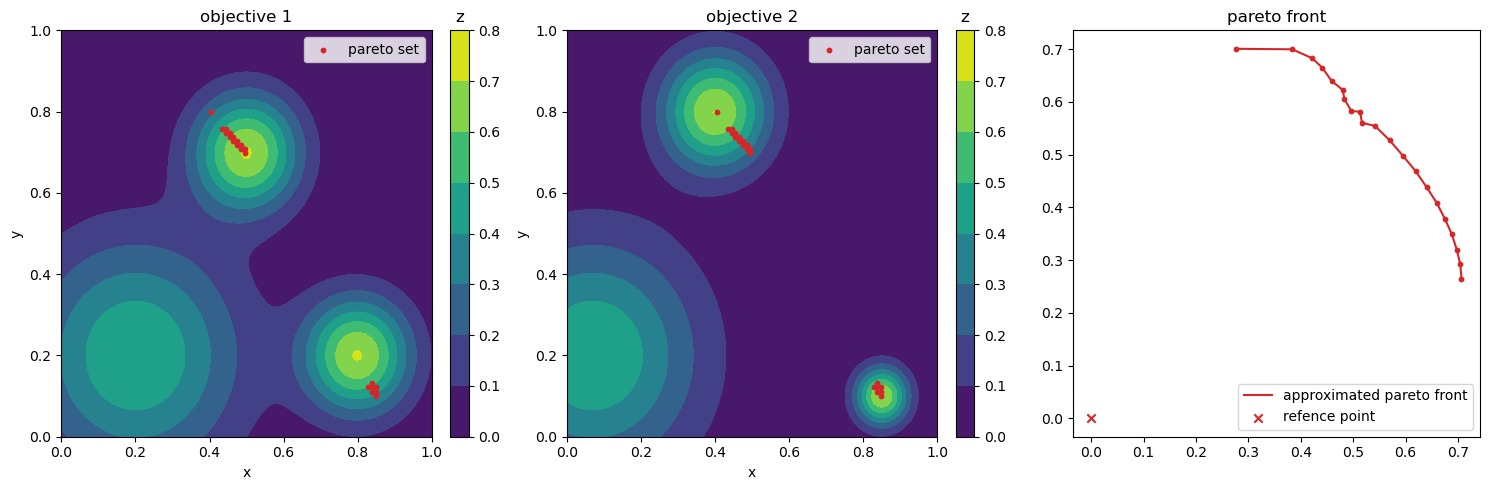

In [5]:
plot_objective(problem, num_samples=100)

In [6]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x.to(**tkwargs), train_obj.to(**tkwargs)

In [7]:
init_x, init_y = generate_initial_data(problem, n=50)

## Generate data

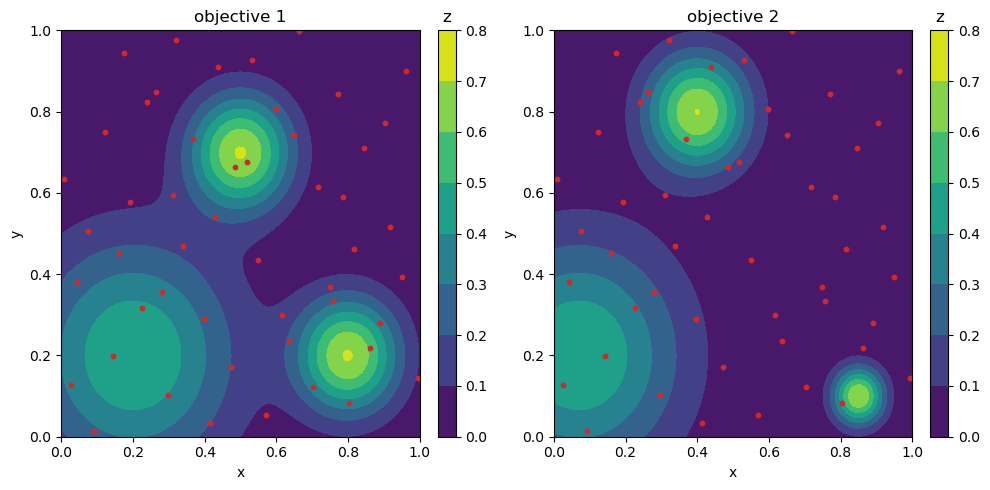

In [8]:
num_dim = problem.bounds.shape[-1]
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.cpu().t()[0], 200
    ),
    np.linspace(
        *problem.bounds.cpu().t()[1], 200
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data).to(**tkwargs)
z = problem(input_data.to(**tkwargs))

fig = plt.figure(figsize=(5 * (num_dim), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].cpu().reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*init_x.cpu().t(), s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')
plt.tight_layout()

In [9]:
from botorch.utils.multi_objective.pareto import is_non_dominated

In [10]:
from modules import SAB, PMA
import torch.nn as nn

DEFAULT_EPS = 1e-10
PADDED_Y_VALUE = -1
tkwargs = {"device": "cpu", "dtype": torch.float}


def hypervolume(y, ref_point):
    bd = DominatedPartitioning(ref_point=ref_point, Y=y)
    volume = bd.compute_hypervolume()
    return volume.view(-1, 1)


def inf_train_gen(dataloader):
    while True:
        for x, y in iter(dataloader): yield x, y
            
def gen_data(pareto_dataset, non_pareto_dataset, ref_point, batch_size):
    # number of x in a set
    max_pareto = pareto_dataset.tensors[0].shape[0]
    pareto_length = torch.randint(low=1, high=max_pareto + 1, size=(1,)).item()

    max_length = pareto_dataset.tensors[0].shape[0] + non_pareto_dataset.tensors[0].shape[0]
    length = torch.randint(low=pareto_length+1, high=max_length + 1, size=(1,)).item()

    pareto_loader = torch.utils.data.DataLoader(
        pareto_dataset,
        batch_size=pareto_length,
        shuffle=True,
        drop_last=True,
    )

    non_pareto_length = min(length - pareto_length, non_pareto_dataset.tensors[0].shape[0])
    non_pareto_loader = torch.utils.data.DataLoader(
        non_pareto_dataset,
        batch_size=non_pareto_length,
        shuffle=True,
        drop_last=True,
    )
    length = pareto_length + non_pareto_length

    pareto_gen = inf_train_gen(pareto_loader)
    non_pareto_gen = inf_train_gen(non_pareto_loader)

    x_samples = torch.empty(0, length, pareto_dataset.tensors[0].shape[-1], **tkwargs)
    y_samples = torch.empty(0, 1, **tkwargs)
    for _ in range(batch_size):
        x_pareto, y_pareto = next(pareto_gen)
        x_non_pareto, y_non_pareto = next(non_pareto_gen)

        x = torch.cat([x_pareto, x_non_pareto], dim=0)
        y = torch.cat([y_pareto, y_non_pareto], dim=0)
        
        x_samples = torch.concat([x_samples, x.unsqueeze(0)], dim=0)
        y_samples = torch.concat([y_samples, hypervolume(y, ref_point)], dim=0)

    return x_samples, y_samples


class SmallSetTransformer(nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.enc = nn.Sequential(
            SAB(dim_in=dim_in, dim_out=64, num_heads=4),
            SAB(dim_in=64, dim_out=64, num_heads=4),
        )
        self.dec = nn.Sequential(
            PMA(dim=64, num_heads=4, num_seeds=1),
            nn.Linear(in_features=64, out_features=1),
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze(-1)


def train_model(model, X_obs, y_obs, ref_point, num_iter=1000):
    pareto = is_non_dominated(y_obs)
    pareto_dataset = torch.utils.data.TensorDataset(*[X_obs[pareto], y_obs[pareto]])
    non_pareto_dataset = torch.utils.data.TensorDataset(*[X_obs[~pareto], y_obs[~pareto]])

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    criterion = listMLE_weighted
    losses = []
    batch_size = 64
    
    model.train()
    for i in range(num_iter):

        if (i+1) % 100 == 0:
            print(f"iteration {i+1}")
    
        x_samples, y_samples = gen_data(pareto_dataset=pareto_dataset, non_pareto_dataset=non_pareto_dataset, ref_point=ref_point, batch_size=batch_size)
#         print("generate samples")
        optimizer.zero_grad()

        preds = model(x_samples)
        loss = criterion(preds.view(1, -1), y_samples.view(1, -1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
#         scheduler.step()
    model.eval()
    return model, losses


# The listMLE_weighted is an extended version of listMLE with weighting added to it.
def listMLE_weighted(y_pred, y_true, eps=DEFAULT_EPS, padded_value_indicator=PADDED_Y_VALUE):
    """
    ListMLE loss introduced in "Listwise Approach to Learning to Rank - Theory and Algorithm".
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: loss value, a torch.Tensor
    """
    # shuffle for randomised tie resolution
    random_indices = torch.randperm(y_pred.shape[-1])
    y_pred_shuffled = y_pred[:, random_indices]
    y_true_shuffled = y_true[:, random_indices]

    y_true_sorted, indices = y_true_shuffled.sort(descending=True, dim=-1)

    mask = y_true_sorted == padded_value_indicator

    preds_sorted_by_true = torch.gather(y_pred_shuffled, dim=1, index=indices)
    preds_sorted_by_true[mask] = float("-inf")

    max_pred_values, _ = preds_sorted_by_true.max(dim=1, keepdim=True)

    preds_sorted_by_true_minus_max = preds_sorted_by_true - max_pred_values

    cumsums = torch.cumsum(preds_sorted_by_true_minus_max.exp().flip(dims=[1]), dim=1).flip(dims=[1])

    observation_loss = torch.log(cumsums + eps) - preds_sorted_by_true_minus_max

    observation_loss[mask] = 0.0

    ####### Weighting extension
    # Weighted ranking because it is more important to get the the first ranks right than the rest.
    weight = np.log(np.arange(observation_loss.shape[-1]) + 2)  # Adding 2 to prevent using log(0) & log(1) as weights.
    weight = np.array(weight, dtype=np.float32)
    weight = torch.from_numpy(weight)[None, :].to(**tkwargs)
    observation_loss = observation_loss / weight
    #######

    return torch.mean(torch.sum(observation_loss, dim=1))

In [11]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [12]:
from botorch.utils.transforms import unnormalize, normalize

class L2R:

    def __init__(self, problem, device="cpu", dtype=torch.float32):
        self.problem = problem
        self.tkwargs = {"dtype": dtype, "device": device}
        self.standard_bounds = torch.zeros(2, problem.dim, **self.tkwargs)
        self.standard_bounds[1] = 1
        # self.n_candidates = min(5000, max(2000, 200 * problem.bounds.shape[-1]))
        self.model = SmallSetTransformer(dim_in=self.problem.dim)
        self.model.to(**self.tkwargs)
        self.n_candidates = 40000

    def fit_model(self, X_obs, y_obs, S):
        self.model, losses = train_model(self.model, X_obs, y_obs, ref_point=problem.ref_point, num_iter=S)

        plt.plot(losses);

    def observe_and_suggest(self, X_obs, y_obs, X_pen=None, batch_size=1, *args, **kwargs):
        # normalize training input
        X_obs_norm = normalize(X_obs, self.problem.bounds).to(**self.tkwargs)
        x_cands = torch.cat(
            (torch.tile(X_obs_norm.unsqueeze(0),(self.n_candidates, 1, 1)),
             input_data.to(**self.tkwargs).unsqueeze(1)),
            dim=1)
        self.fit_model(X_obs_norm, y_obs, S=1000)
        with torch.no_grad():
            scores = self.model(x_cands)
        candidates = input_data[scores.argmax()].unsqueeze(0)
        new_x = unnormalize(candidates.detach(), bounds=self.problem.bounds)

        fig = plt.figure(figsize=(8, 4))

        # plot aggregated results
        ax_agg = plt.subplot2grid((1, 2), (0, 0))
        div = make_axes_locatable(ax_agg)
        cax = div.append_axes('right', '5%', '5%')
        countourset = ax_agg.contourf(
            xx,
            yy,
            scores.cpu().reshape(xx.shape),
        )
        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
        ax_agg.scatter(*X_obs.t(), color='tab:red', alpha=0.2)

        ax_agg.set_xlabel('x1')
        ax_agg.set_ylabel('x2')
        ax_agg.set_title(f"aggregated results")
        clb.ax.set_title('z')

        # plot pareto results
        bd = DominatedPartitioning(ref_point=self.problem.ref_point, Y=y_obs)
        nbd = FastNondominatedPartitioning(ref_point=self.problem.ref_point, Y=y_obs)
        u_pareto, pareto = bd.hypercell_bounds
        ndom, _ = nbd.hypercell_bounds
        ax_pareto = plt.subplot2grid((1, 2), (0, 1))
        is_pareto = is_non_dominated(y_obs)
        ax_pareto.scatter(*y_obs[~is_pareto].cpu().t(), s=10, alpha=0.3)

        ax_pareto.scatter(*pareto.cpu().t(), s=10, color='tab:red', label="pareto")
        ax_pareto.plot(*pareto.cpu().t(), color='tab:red')

        boxes = [Rectangle(
            l_point.cpu(),
            *(u_point - l_point).cpu(),
        ) for l_point, u_point in zip(pareto, u_pareto)]
        pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
        pc.set_array(torch.arange(0, len(pareto)))
        ax_pareto.add_collection(pc)

        ax_pareto.scatter(*self.problem.ref_point.cpu().t(), color='k', s=10, label="ref point")
        ax_pareto.scatter(*ndom.cpu().t(), s=10, label="non dominated", color='tab:purple')
        new_y = self.problem(new_x) 
        ax_pareto.scatter(*new_y.cpu().t(), marker='x', color='tab:orange', label="candidates")

        ax_pareto.set_xlabel('y1')
        ax_pareto.set_ylabel('y2')
        ax_pareto.set_xlim(self.problem.ref_point[0].item())
        ax_pareto.set_ylim(self.problem.ref_point[1].item())
        ax_pareto.set_title('pareto')
        ax_pareto.legend()
        
        plt.tight_layout()
        plt.show()
        return new_x

iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000


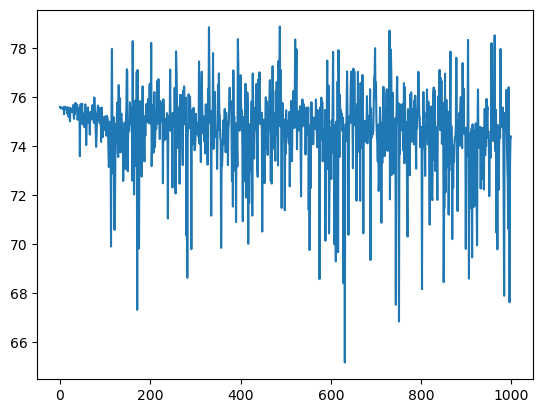

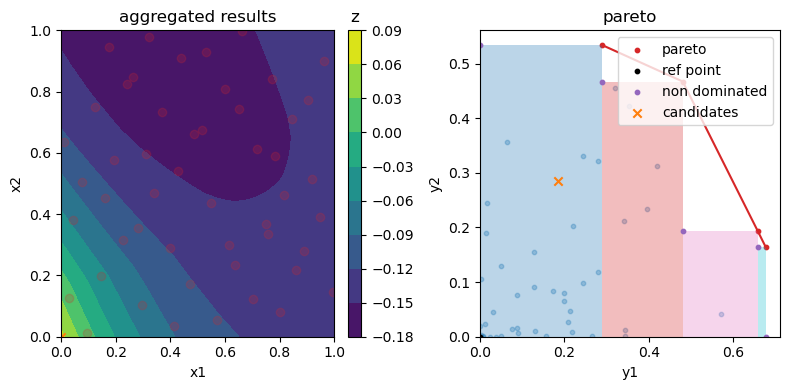

In [13]:
x_obs = init_x
y_obs = init_y

optimizer = L2R(problem)

for _ in range(1):
    new_x = optimizer.observe_and_suggest(x_obs, y_obs)
    new_y = problem(new_x) 
    x_obs = torch.cat([x_obs, new_x])
    y_obs = torch.cat([y_obs, new_y])